<a href="https://colab.research.google.com/github/BelKaty/BelKaProject/blob/main/HW6_NN_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from PIL import Image
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Cropping2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
# Извлеките данные из zip-файлов
with zipfile.ZipFile('train.zip', 'r') as data_r:
    data_r.extractall()

In [3]:
with zipfile.ZipFile('test.zip', 'r') as data_r:
    data_r.extractall()

In [4]:
# Функция загрузки данных
def download_data(path):
    data = []
    for path_image in sorted(os.listdir(path=path)):
        image = Image.open(path + path_image)  # Открыть изображение
        data.append(np.array(image))  # Загрузить пиксели
    return data

In [5]:
# Загрузка данных обучения и тестирования
X_train = download_data("train/images/")
Y_train = download_data("train/masks/")
X_test = download_data("test/images/")
Y_test = download_data("test/masks/")

array([[[226, 230, 241],
        [216, 220, 231],
        [234, 236, 248],
        ...,
        [205, 203, 208],
        [210, 208, 213],
        [214, 212, 217]],

       [[246, 248, 255],
        [234, 236, 248],
        [237, 239, 251],
        ...,
        [200, 198, 203],
        [205, 203, 208],
        [209, 207, 212]],

       [[244, 244, 254],
        [228, 228, 238],
        [234, 234, 244],
        ...,
        [214, 209, 215],
        [208, 203, 209],
        [201, 196, 202]],

       ...,

       [[243, 233, 223],
        [249, 239, 229],
        [255, 245, 235],
        ...,
        [ 18,  17,  35],
        [ 64,  59,  82],
        [115, 107, 131]],

       [[253, 243, 233],
        [244, 234, 224],
        [252, 242, 232],
        ...,
        [ 29,  28,  46],
        [ 53,  48,  71],
        [114, 106, 130]],

       [[254, 244, 234],
        [236, 226, 216],
        [246, 236, 226],
        ...,
        [ 94,  93, 111],
        [ 64,  59,  82],
        [115, 107, 131]]], dtype=uint8)
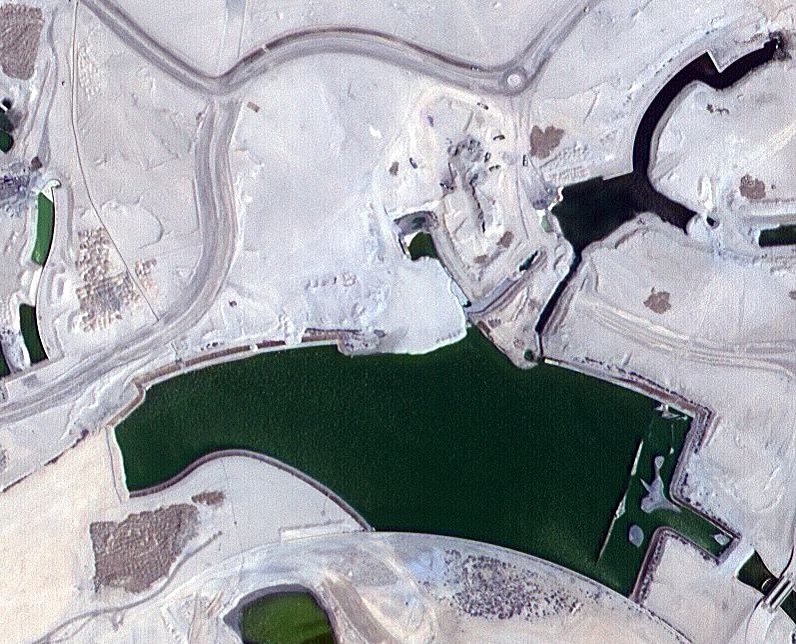

In [6]:
X_train[1]

In [7]:
#Функция изменения размера изображения
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask

In [8]:
X_train, Y_train = resize(X_train, Y_train)

In [9]:
X_test, Y_test = resize(X_test, Y_test)

In [10]:
# Определить цветовую палитру
palette = {
    0: (60, 16, 152),  # Building
    1: (132, 41, 246),  # Land
    2: (110, 193, 228),  # Road
    3: (254, 221, 58),  # Vegetation
    4: (226, 169, 41),  # Water
    5: (155, 155, 155)  # Unlabeled
}

In [11]:
invert_palette = {v: k for k, v in palette.items()}

In [12]:
# сегментация нейронной сети в RGB изображение
def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

In [13]:
def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.int8) # принадлежность каждого пикселя классу
    min_distance = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.float32)+1000 # расстояние до ближайшего класса для пикселей
    for c, i in palette.items():
      distance = np.sum((arr_3d - np.array(c).reshape(1, 1, 3))**2, axis=-1)**(1/2) # ищем расстояние для каждого пикселя до проверяемого класса по евклиду рас-ие
      condition = min_distance > distance # поиск элементов меньше min_distance
      min_distance[condition] = distance[condition] # замена дистанции найденных элементов
      arr_2d[condition] = i # замена класса найденных элементов

    for c, i in palette.items():
      m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
      arr_2d[m] = i

    arr_2d = arr_2d.tolist()
    for i in range(len(arr_2d)):
      for j in range(len(arr_2d[0])):
        label = [0, 0, 0, 0, 0, 0]
        label[arr_2d[i][j]] = 1
        arr_2d[i][j] = label
    arr_2d = np.array(arr_2d)

    return arr_2d

In [14]:
X_train_pred = np.array(X_train).reshape([7, 128, 128, 3])/255
X_test_pred = np.array(X_test).reshape([2, 128, 128, 3])/255
Y_train_pred = []
for i in range(len(Y_train)):
  Y_train_pred.append(convert_from_color(Y_train[i][:, :, :3]))
Y_train_pred = np.array(Y_train_pred)
Y_test_pred = []
for i in range(len(Y_test)):
  Y_test_pred.append(convert_from_color(Y_test[i][:, :, :3]))
Y_test_pred = np.array(Y_test_pred)

In [15]:
import numpy as np
from keras import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [16]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [17]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [18]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

In [19]:
# Определить архитектуру U-Net
def unet():
   # inputs
   inputs = layers.Input(shape=(128,128,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(6, 1, padding="same", activation = "softmax")(u9)
   # модель unet с Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [20]:
unet_model = unet()

In [21]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="categorical_crossentropy",
                  metrics="accuracy")

In [22]:
%%time

history = unet_model.fit(X_train_pred, Y_train_pred,  epochs=10, validation_data = (X_test_pred, Y_test_pred))

Epoch 1/10
1/1 [==============================] - 22s 22s/step - loss: 2.8971 - accuracy: 0.0601 - val_loss: 1.3053 - val_accuracy: 0.5964
Epoch 2/10
1/1 [==============================] - 14s 14s/step - loss: 1.3342 - accuracy: 0.5761 - val_loss: 1.1352 - val_accuracy: 0.6049
Epoch 3/10
1/1 [==============================] - 14s 14s/step - loss: 1.1099 - accuracy: 0.6260 - val_loss: 1.0643 - val_accuracy: 0.6051
Epoch 4/10
1/1 [==============================] - 14s 14s/step - loss: 1.1204 - accuracy: 0.6272 - val_loss: 1.0396 - val_accuracy: 0.6051
Epoch 5/10
1/1 [==============================] - 14s 14s/step - loss: 1.0794 - accuracy: 0.6272 - val_loss: 1.0348 - val_accuracy: 0.6051
Epoch 6/10
1/1 [==============================] - 15s 15s/step - loss: 1.0451 - accuracy: 0.6272 - val_loss: 1.0591 - val_accuracy: 0.6052
Epoch 7/10
1/1 [==============================] - 15s 15s/step - loss: 1.0455 - accuracy: 0.6277 - val_loss: 1.0603 - val_accuracy: 0.6052
Epoch 8/10
1/1 [===========

Данный скрипт реализует сегментацию изображения с помощью модели U-Net, используя данные из zip-архивов, которые были предварительно обработаны путем изменения размера изображений и масок до 128x128 пикселей. Модель U-Net задается с использованием функционального API Keras и обучается на предварительно обработанных данных за 10 эпох. Модель компилируется с использованием оптимизатора Adam и категориальной кросс-энтропийной потерей, а ход обучения отслеживается с помощью метрики точности. В сценарии применяются библиотеки TensorFlow и Keras для глубокого обучения и обработки изображений. В данном скрипте используется модифицированная версия архитектуры U-Net, принимающая изображения RGB в качестве входных данных и генерирующая маску с шестью классами. Кроме того, скрипт включает в себя аугментацию данных за счет случайных преобразований входных изображений в процессе обучения.





